# Gradient Boosting Models for Medical Diagnosis

## Experiment Overview

This notebook trains three gradient boosting algorithms:
1. **LightGBM** - Fast, efficient, handles categorical features well
2. **XGBoost** - Robust, excellent performance, handles missing values
3. **CatBoost** - Best for categorical data, minimal hyperparameter tuning

### Dataset
- Using pre-filtered datasets (evidence features already encoded, raw columns removed)
- Training: preprocessed_filtered/train_filtered.csv
- Validation: preprocessed_filtered/validation_filtered.csv
- Test: preprocessed_filtered/test_filtered.csv

### Evaluation Metrics
- Accuracy, Macro F1-score, Weighted F1-score, Top-3 Accuracy

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Model libraries
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## Load Datasets

Load the pre-filtered datasets that already have evidence features encoded.

In [2]:
# Load filtered datasets
base_path = "/Users/zeynep_yilmaz/Desktop/sdp_gregDDx/DDxPlus Dataset/preprocessed_filtered/"
train_df = pd.read_csv(f"{base_path}train_filtered.csv")
val_df = pd.read_csv(f"{base_path}validation_filtered.csv")
test_df = pd.read_csv(f"{base_path}test_filtered.csv")

# Drop raw 'SEX' and 'DIFFERENTIAL_DIAGNOSIS' columns to prevent leakage
train_df = train_df.drop(columns=['SEX', 'DIFFERENTIAL_DIAGNOSIS'], errors='ignore')
val_df = val_df.drop(columns=['SEX', 'DIFFERENTIAL_DIAGNOSIS'], errors='ignore')
test_df = test_df.drop(columns=['SEX', 'DIFFERENTIAL_DIAGNOSIS'], errors='ignore')
print("  Dropped raw SEX and DIFFERENTIAL_DIAGNOSIS columns.\n")

# Drop raw 'SEX' and 'DIFFERENTIAL_DIAGNOSIS' columns to prevent leakage
train_df = train_df.drop(columns=['SEX', 'DIFFERENTIAL_DIAGNOSIS'], errors='ignore')
val_df = val_df.drop(columns=['SEX', 'DIFFERENTIAL_DIAGNOSIS'], errors='ignore')
test_df = test_df.drop(columns=['SEX', 'DIFFERENTIAL_DIAGNOSIS'], errors='ignore')
print("  Dropped raw SEX and DIFFERENTIAL_DIAGNOSIS columns.\n")

# Load label encoder
with open("/Users/zeynep_yilmaz/Desktop/sdp_gregDDx/DDxPlus Dataset/pkl files/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

print("✓ Datasets loaded successfully!")
print(f"  Training: {train_df.shape}")
print(f"  Validation: {val_df.shape}")
print(f"  Test: {test_df.shape}")
print(f"  Total pathologies: {len(label_encoder.classes_)}")

  Dropped raw SEX and DIFFERENTIAL_DIAGNOSIS columns.

  Dropped raw SEX and DIFFERENTIAL_DIAGNOSIS columns.

✓ Datasets loaded successfully!
  Training: (936888, 592)
  Validation: (129258, 592)
  Test: (142184, 592)
  Total pathologies: 49


## Feature Selection

Select features for training. Exclude non-feature columns and prepare X and y.

In [3]:
# Feature selection + breakdown + data prep (uses filtered datasets)
non_feature_cols = ['PATHOLOGY', 'PATHOLOGY_ENCODED'] # SEX and DIFFERENTIAL_DIAGNOSIS already dropped
feature_cols = [col for col in train_df.columns if col not in non_feature_cols]

print(f'Total columns: {train_df.shape[1]}')
print(f'Selected features: {len(feature_cols)}')

demo_features = [c for c in feature_cols if c in ['AGE', 'SEX_ENCODED']]
evidence_features = [c for c in feature_cols if c.startswith('evidence_')]
initial_features = [c for c in feature_cols if c.startswith('initial_')]

print('Feature breakdown:')
print(f'  - Demographics: {len(demo_features)} ({demo_features})')
print(f'  - Evidence features: {len(evidence_features)}')
print(f'  - Initial evidence features: {len(initial_features)}')
print(f'Total features: {len(feature_cols)}')

# Prepare X and y
X_train = train_df[feature_cols]; y_train = train_df['PATHOLOGY_ENCODED']
X_val   =  val_df[feature_cols]; y_val   =  val_df['PATHOLOGY_ENCODED']
X_test  = test_df[feature_cols]; y_test  = test_df['PATHOLOGY_ENCODED']

print('✓ Data prepared:')
print(f'  X_train: {X_train.shape} | X_val: {X_val.shape} | X_test: {X_test.shape}')


Total columns: 592
Selected features: 590
Feature breakdown:
  - Demographics: 2 (['AGE', 'SEX_ENCODED'])
  - Evidence features: 492
  - Initial evidence features: 96
Total features: 590
✓ Data prepared:
  X_train: (936888, 590) | X_val: (129258, 590) | X_test: (142184, 590)


In [5]:
# DETAILED DATA LEAKAGE DIAGNOSTICS (Post-filtering)
print("" + "="*80)
print("DETAILED DATA LEAKAGE DIAGNOSTICS")
print("Expected features: AGE, SEX_ENCODED, evidence_*, initial_*")


print("Excluded columns (verified): PATHOLOGY, PATHOLOGY_ENCODED, DIFFERENTIAL_DIAGNOSIS, SEX\n")
import re
def is_icd10(code):
    patterns = [
        r'^[A-Z][0-9]{1,4}(\.[0-9]{1,2})?$',
        r'^[a-z][0-9]+(-|_)[0-9]+$',
        r'^[a-z]{1,2}[0-9]+(\.[0-9]+)+$',
        r'^[A-Z][0-9]{2,4}.*$'
    ]
    return any(re.match(p, code) for p in patterns)

# 1. Verify Dataset Columns
print("1. Verifying dataset columns:")
current_cols = set(train_df.columns)
expected_cols_for_check = ['AGE', 'SEX_ENCODED', 'PATHOLOGY', 'PATHOLOGY_ENCODED'] # only basic columns + target
unexpected_non_features = [col for col in current_cols if col not in expected_cols_for_check and not (col.startswith('evidence_') or col.startswith('initial_'))]
if unexpected_non_features:
    print(f"  ❌ UNEXPECTED NON-FEATURE COLUMNS FOUND: {unexpected_non_features}")
else:
    print("  ✓ No unexpected non-feature columns detected.")

# Confirm key excluded columns are absent
explicitly_excluded = ['NUM_DIFFERENTIAL_DX', 'NUM_EVIDENCES']
for col in explicitly_excluded:
    if col in current_cols:
        print(f"  ❌ LEAKAGE: Expected excluded column '{col}' is present!")
    else:
        print(f"  ✓ Excluded column '{col}' is absent.")

print(f"  Total features for model: {len(feature_cols)}")

# 2. Re-check for ICD-10 Codes in Encoded Features
print("2. Re-checking for ICD-10 patterns in encoded features:")
icd10_in_evidence_features = [c for c in feature_cols if c.startswith('evidence_') and is_icd10(c.replace('evidence_', ''))]
icd10_in_initial_features = [c for c in feature_cols if c.startswith('initial_') and is_icd10(c.replace('initial_', ''))]
if icd10_in_evidence_features:
    print(f"  ❌ LEAKAGE: {len(icd10_in_evidence_features)} ICD-10 patterns found in evidence features: {icd10_in_evidence_features[:5]}...")
if icd10_in_initial_features:
    print(f"  ❌ LEAKAGE: {len(icd10_in_initial_features)} ICD-10 patterns found in initial features: {icd10_in_initial_features[:5]}...")
if not icd10_in_evidence_features and not icd10_in_initial_features:
    print("  ✓ No ICD-10 patterns found in encoded evidence or initial evidence features.")

# 3. Detailed Correlation Analysis with Target
print("3. Detailed correlation analysis with PATHOLOGY_ENCODED (top 10):")
correlations = {}
for col in feature_cols:
    try:
        corr = train_df[col].corr(train_df['PATHOLOGY_ENCODED'])
        if pd.notna(corr):
            correlations[col] = abs(corr)
    except: pass

sorted_correlations = sorted(correlations.items(), key=lambda item: item[1], reverse=True)

suspicious_corr_threshold = 0.5 # A high threshold for suspiciousness
highly_correlated = []
for feat, corr_val in sorted_correlations:
    if corr_val > suspicious_corr_threshold:
        highly_correlated.append((feat, corr_val))

if highly_correlated:
    print(f"  ⚠️  FOUND {len(highly_correlated)} FEATURES WITH CORRELATION > {suspicious_corr_threshold}:")
    for feat, corr_val in highly_correlated[:10]:
        print(f"    - {feat}: {corr_val:.4f}")
        # Inspect values for extremely high correlation features
        if corr_val > 0.8: # Even higher threshold for direct inspection
            print(f"      Unique values/counts for {feat}:\n{train_df[feat].value_counts().head(5)}")
else:
    print("  ✓ No features with exceptionally high correlation (>0.5) to target found.")

# 4. Final Sanity Check for Differential Diagnosis Presence
print("4. Final check for 'DIFFERENTIAL_DIAGNOSIS' and 'SEX' columns (should be absent):")
if 'DIFFERENTIAL_DIAGNOSIS' in train_df.columns:
    print("  ❌ LEAKAGE: 'DIFFERENTIAL_DIAGNOSIS' column still exists!")
else:
    print("  ✓ 'DIFFERENTIAL_DIAGNOSIS' column is absent.")
if 'SEX' in train_df.columns:
    print("  ❌ LEAKAGE: 'SEX' column still exists!")
else:
    print("  ✓ 'SEX' column is absent.")


DETAILED DATA LEAKAGE DIAGNOSTICS
Expected features: AGE, SEX_ENCODED, evidence_*, initial_*
Excluded columns (verified): PATHOLOGY, PATHOLOGY_ENCODED, DIFFERENTIAL_DIAGNOSIS, SEX

1. Verifying dataset columns:
  ✓ No unexpected non-feature columns detected.
  ✓ Excluded column 'NUM_DIFFERENTIAL_DX' is absent.
  ✓ Excluded column 'NUM_EVIDENCES' is absent.
  Total features for model: 590
2. Re-checking for ICD-10 patterns in encoded features:
  ✓ No ICD-10 patterns found in encoded evidence or initial evidence features.
3. Detailed correlation analysis with PATHOLOGY_ENCODED (top 10):
  ✓ No features with exceptionally high correlation (>0.5) to target found.
4. Final check for 'DIFFERENTIAL_DIAGNOSIS' and 'SEX' columns (should be absent):
  ✓ 'DIFFERENTIAL_DIAGNOSIS' column is absent.
  ✓ 'SEX' column is absent.


## Model 1: LightGBM

In [6]:
# LightGBM
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(label_encoder.classes_),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

print("Training LightGBM...")
start_time = time.time()

train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, free_raw_data=False)

lgb_model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

training_time = time.time() - start_time
print(f"✓ LightGBM trained in {training_time:.2f} seconds")

# Predictions
y_val_pred_proba = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# Evaluate
lgb_accuracy = accuracy_score(y_val, y_val_pred)
lgb_f1_macro = f1_score(y_val, y_val_pred, average='macro')
lgb_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
top3_pred = np.argsort(y_val_pred_proba, axis=1)[:, -3:]
top3_accuracy = np.mean([y_val.iloc[i] in top3_pred[i] for i in range(len(y_val))])

print("\n" + "="*80)
print("LIGHTGBM VALIDATION RESULTS")
print("="*80)
print(f"Accuracy: {lgb_accuracy:.4f}")
print(f"Macro F1-score: {lgb_f1_macro:.4f}")
print(f"Weighted F1-score: {lgb_f1_weighted:.4f}")
print(f"Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"Training time: {training_time:.2f} seconds")

lgb_results = {
    'accuracy': lgb_accuracy,
    'f1_macro': lgb_f1_macro,
    'f1_weighted': lgb_f1_weighted,
    'top3_accuracy': top3_accuracy,
    'training_time': training_time
}

# === Save model ===
from pathlib import Path
_save_dir = Path('../saved_models')
_save_dir.mkdir(parents=True, exist_ok=True)
# Save LightGBM model
_lgb_path = _save_dir / 'lightgbm_model.txt'
lgb_model.save_model(str(_lgb_path))
print('Saved LightGBM model to {}'.format(_lgb_path))


Training LightGBM...
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 33.3934	val's multi_logloss: 33.4862
Early stopping, best iteration is:
[16]	train's multi_logloss: 0.0803444	val's multi_logloss: 0.0632999
✓ LightGBM trained in 34.18 seconds

LIGHTGBM VALIDATION RESULTS
Accuracy: 0.9962
Macro F1-score: 0.9852
Weighted F1-score: 0.9962
Top-3 Accuracy: 0.9995
Training time: 34.18 seconds


## Model 2: XGBoost

In [7]:
# XGBoost
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

print("Training XGBoost...")
start_time = time.time()

xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=50)

training_time = time.time() - start_time
print(f"✓ XGBoost trained in {training_time:.2f} seconds")

# Predictions
y_val_pred = xgb_model.predict(X_val)
y_val_pred_proba = xgb_model.predict_proba(X_val)

# Evaluate
xgb_accuracy = accuracy_score(y_val, y_val_pred)
xgb_f1_macro = f1_score(y_val, y_val_pred, average='macro')
xgb_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
top3_pred = np.argsort(y_val_pred_proba, axis=1)[:, -3:]
top3_accuracy = np.mean([y_val.iloc[i] in top3_pred[i] for i in range(len(y_val))])

print("\n" + "="*80)
print("XGBOOST VALIDATION RESULTS")
print("="*80)
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Macro F1-score: {xgb_f1_macro:.4f}")
print(f"Weighted F1-score: {xgb_f1_weighted:.4f}")
print(f"Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"Training time: {training_time:.2f} seconds")

xgb_results = {
    'accuracy': xgb_accuracy,
    'f1_macro': xgb_f1_macro,
    'f1_weighted': xgb_f1_weighted,
    'top3_accuracy': top3_accuracy,
    'training_time': training_time
}

# === Save model ===
from pathlib import Path
_save_dir = Path('../saved_models')
_save_dir.mkdir(parents=True, exist_ok=True)
# Save XGBoost model
_xgb_path = _save_dir / 'xgboost_model.json'
xgb_model.save_model(str(_xgb_path))
print('Saved XGBoost model to {}'.format(_xgb_path))


Training XGBoost...
[0]	validation_0-mlogloss:1.66709	validation_1-mlogloss:1.66687
[50]	validation_0-mlogloss:0.01996	validation_1-mlogloss:0.01970
[100]	validation_0-mlogloss:0.00783	validation_1-mlogloss:0.00838
[150]	validation_0-mlogloss:0.00645	validation_1-mlogloss:0.00810
[200]	validation_0-mlogloss:0.00555	validation_1-mlogloss:0.00813
[218]	validation_0-mlogloss:0.00524	validation_1-mlogloss:0.00817
✓ XGBoost trained in 589.93 seconds

XGBOOST VALIDATION RESULTS
Accuracy: 0.9972
Macro F1-score: 0.9964
Weighted F1-score: 0.9972
Top-3 Accuracy: 1.0000
Training time: 589.93 seconds


## Model 3: CatBoost

In [8]:
# CatBoost
cat_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=42,
    verbose=50,
    early_stopping_rounds=50
)

print("Training CatBoost...")
start_time = time.time()

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

training_time = time.time() - start_time
print(f"✓ CatBoost trained in {training_time:.2f} seconds")

# Predictions
y_val_pred = cat_model.predict(X_val)
y_val_pred_proba = cat_model.predict_proba(X_val)

# Evaluate
cat_accuracy = accuracy_score(y_val, y_val_pred)
cat_f1_macro = f1_score(y_val, y_val_pred, average='macro')
cat_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
top3_pred = np.argsort(y_val_pred_proba, axis=1)[:, -3:]
top3_accuracy = np.mean([y_val.iloc[i] in top3_pred[i] for i in range(len(y_val))])

print("\n" + "="*80)
print("CATBOOST VALIDATION RESULTS")
print("="*80)
print(f"Accuracy: {cat_accuracy:.4f}")
print(f"Macro F1-score: {cat_f1_macro:.4f}")
print(f"Weighted F1-score: {cat_f1_weighted:.4f}")
print(f"Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"Training time: {training_time:.2f} seconds")

cat_results = {
    'accuracy': cat_accuracy,
    'f1_macro': cat_f1_macro,
    'f1_weighted': cat_f1_weighted,
    'top3_accuracy': top3_accuracy,
    'training_time': training_time
}

# === Save model ===
from pathlib import Path
_save_dir = Path('../saved_models')
_save_dir.mkdir(parents=True, exist_ok=True)
# Save CatBoost model
_cat_path = _save_dir / 'catboost_model.cbm'
cat_model.save_model(str(_cat_path))
print('Saved CatBoost model to {}'.format(_cat_path))


Training CatBoost...
0:	learn: 3.0563563	test: 3.0973136	best: 3.0973136 (0)	total: 4.31s	remaining: 1h 11m 47s
50:	learn: 0.2690020	test: 0.2643321	best: 0.2643321 (50)	total: 3m 40s	remaining: 1h 8m 17s
100:	learn: 0.1065312	test: 0.1045126	best: 0.1045126 (100)	total: 7m 30s	remaining: 1h 6m 51s
150:	learn: 0.0523907	test: 0.0511923	best: 0.0511923 (150)	total: 11m 7s	remaining: 1h 2m 30s
200:	learn: 0.0327515	test: 0.0320012	best: 0.0320012 (200)	total: 14m 35s	remaining: 57m 59s
250:	learn: 0.0236896	test: 0.0231026	best: 0.0231026 (250)	total: 18m 7s	remaining: 54m 5s
300:	learn: 0.0187574	test: 0.0182012	best: 0.0182012 (300)	total: 21m 36s	remaining: 50m 11s
350:	learn: 0.0155781	test: 0.0151352	best: 0.0151352 (350)	total: 24m 56s	remaining: 46m 6s
400:	learn: 0.0136951	test: 0.0134459	best: 0.0134459 (400)	total: 28m 14s	remaining: 42m 11s
450:	learn: 0.0125690	test: 0.0124884	best: 0.0124884 (450)	total: 31m 35s	remaining: 38m 27s
500:	learn: 0.0117275	test: 0.0118217	best: 

## Test Set Evaluation

Now let's evaluate all models on the true test set to get final results.

In [12]:
# Evaluate on test set
print("="*80)
print("TEST SET EVALUATION")
print("="*80)

# LightGBM test predictions
y_test_pred_proba_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_test_pred_lgb = np.argmax(y_test_pred_proba_lgb, axis=1)

# XGBoost test predictions
y_test_pred_xgb = xgb_model.predict(X_test)
y_test_pred_proba_xgb = xgb_model.predict_proba(X_test)

# CatBoost test predictions
try:
    y_test_pred_cat = cat_model.predict(X_test)
    y_test_pred_proba_cat = cat_model.predict_proba(X_test)
except:
    print("CatBoost model not available for test evaluation")
    y_test_pred_cat = None
    y_test_pred_proba_cat = None

# Calculate test metrics for each model
test_results = {}

# LightGBM
test_acc_lgb = accuracy_score(y_test, y_test_pred_lgb)
test_f1_macro_lgb = f1_score(y_test, y_test_pred_lgb, average='macro')
test_f1_weighted_lgb = f1_score(y_test, y_test_pred_lgb, average='weighted')
top3_pred_lgb = np.argsort(y_test_pred_proba_lgb, axis=1)[:, -3:]
top3_acc_lgb = np.mean([y_test.iloc[i] in top3_pred_lgb[i] for i in range(len(y_test))])

test_results['LightGBM'] = {
    'accuracy': test_acc_lgb,
    'f1_macro': test_f1_macro_lgb,
    'f1_weighted': test_f1_weighted_lgb,
    'top3_accuracy': top3_acc_lgb
}

print("\nLightGBM Test Results:")
print(f"  Accuracy: {test_acc_lgb:.4f}")
print(f"  Macro F1: {test_f1_macro_lgb:.4f}")
print(f"  Weighted F1: {test_f1_weighted_lgb:.4f}")
print(f"  Top-3 Accuracy: {top3_acc_lgb:.4f}")

# XGBoost
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_f1_macro_xgb = f1_score(y_test, y_test_pred_xgb, average='macro')
test_f1_weighted_xgb = f1_score(y_test, y_test_pred_xgb, average='weighted')
top3_pred_xgb = np.argsort(y_test_pred_proba_xgb, axis=1)[:, -3:]
top3_acc_xgb = np.mean([y_test.iloc[i] in top3_pred_xgb[i] for i in range(len(y_test))])

test_results['XGBoost'] = {
    'accuracy': test_acc_xgb,
    'f1_macro': test_f1_macro_xgb,
    'f1_weighted': test_f1_weighted_xgb,
    'top3_accuracy': top3_acc_xgb
}

print("\nXGBoost Test Results:")
print(f"  Accuracy: {test_acc_xgb:.4f}")
print(f"  Macro F1: {test_f1_macro_xgb:.4f}")
print(f"  Weighted F1: {test_f1_weighted_xgb:.4f}")
print(f"  Top-3 Accuracy: {top3_acc_xgb:.4f}")

# CatBoost
if y_test_pred_cat is not None:
    test_acc_cat = accuracy_score(y_test, y_test_pred_cat)
    test_f1_macro_cat = f1_score(y_test, y_test_pred_cat, average='macro')
    test_f1_weighted_cat = f1_score(y_test, y_test_pred_cat, average='weighted')
    top3_pred_cat = np.argsort(y_test_pred_proba_cat, axis=1)[:, -3:]
    top3_acc_cat = np.mean([y_test.iloc[i] in top3_pred_cat[i] for i in range(len(y_test))])

    test_results['CatBoost'] = {
        'accuracy': test_acc_cat,
        'f1_macro': test_f1_macro_cat,
        'f1_weighted': test_f1_weighted_cat,
        'top3_accuracy': top3_acc_cat
    }

    print("\nCatBoost Test Results:")
    print(f"  Accuracy: {test_acc_cat:.4f}")
    print(f"  Macro F1: {test_f1_macro_cat:.4f}")
    print(f"  Weighted F1: {test_f1_weighted_cat:.4f}")
    print(f"  Top-3 Accuracy: {top3_acc_cat:.4f}")

# Create test comparison
test_comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost'],
    'Accuracy': [test_acc_lgb, test_acc_xgb, test_acc_cat if y_test_pred_cat is not None else 0],
    'Macro F1': [test_f1_macro_lgb, test_f1_macro_xgb, test_f1_macro_cat if y_test_pred_cat is not None else 0],
    'Weighted F1': [test_f1_weighted_lgb, test_f1_weighted_xgb, test_f1_weighted_cat if y_test_pred_cat is not None else 0],
    'Top-3 Accuracy': [top3_acc_lgb, top3_acc_xgb, top3_acc_cat if y_test_pred_cat is not None else 0]
})

print("\n" + "="*80)
print("TEST SET COMPARISON")
print("="*80)
print(test_comparison.to_string(index=False))

TEST SET EVALUATION

LightGBM Test Results:
  Accuracy: 0.9960
  Macro F1: 0.9843
  Weighted F1: 0.9960
  Top-3 Accuracy: 0.9995

XGBoost Test Results:
  Accuracy: 0.9972
  Macro F1: 0.9964
  Weighted F1: 0.9972
  Top-3 Accuracy: 1.0000

CatBoost Test Results:
  Accuracy: 0.9972
  Macro F1: 0.9964
  Weighted F1: 0.9971
  Top-3 Accuracy: 1.0000

TEST SET COMPARISON
   Model  Accuracy  Macro F1  Weighted F1  Top-3 Accuracy
LightGBM  0.996033  0.984280     0.996016        0.999536
 XGBoost  0.997201  0.996427     0.997174        1.000000
CatBoost  0.997152  0.996377     0.997125        1.000000


## Model Comparison

MODEL COMPARISON
   Model  Accuracy  Macro F1  Weighted F1  Top-3 Accuracy
LightGBM  0.996178  0.985230     0.996162        0.999505
 XGBoost  0.997238  0.996389     0.997208        1.000000
CatBoost  0.996898  0.996102     0.996868        1.000000


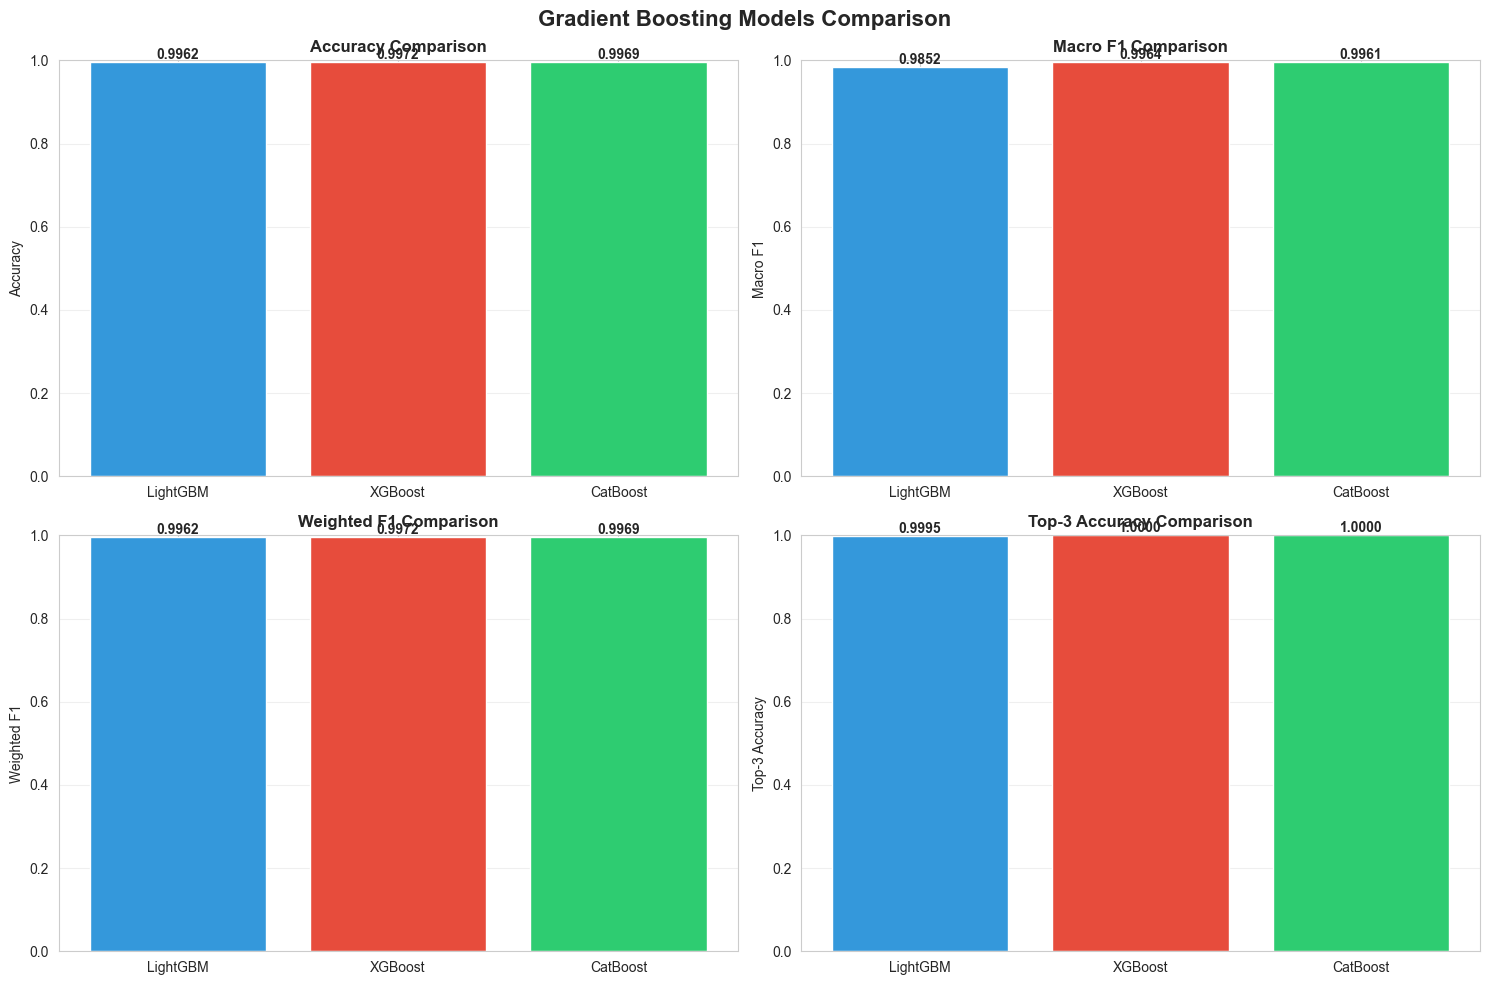

In [13]:
# Create comparison
comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost'],
    'Accuracy': [lgb_accuracy, xgb_accuracy, cat_accuracy],
    'Macro F1': [lgb_f1_macro, xgb_f1_macro, cat_f1_macro],
    'Weighted F1': [lgb_f1_weighted, xgb_f1_weighted, cat_f1_weighted],
    'Top-3 Accuracy': [lgb_results['top3_accuracy'], xgb_results['top3_accuracy'], cat_results['top3_accuracy']]
})

print("="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison.to_string(index=False))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Gradient Boosting Models Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Macro F1', 'Weighted F1', 'Top-3 Accuracy']
for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    axes[row, col].bar(comparison['Model'], comparison[metric], color=['#3498db', '#e74c3c', '#2ecc71'])
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(metric)
    axes[row, col].set_ylim([0, 1])
    axes[row, col].grid(True, alpha=0.3, axis='y')
    
    for j, v in enumerate(comparison[metric]):
        axes[row, col].text(j, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Investigation: Why Are Results So High?

Let's investigate what's driving the suspiciously high performance.

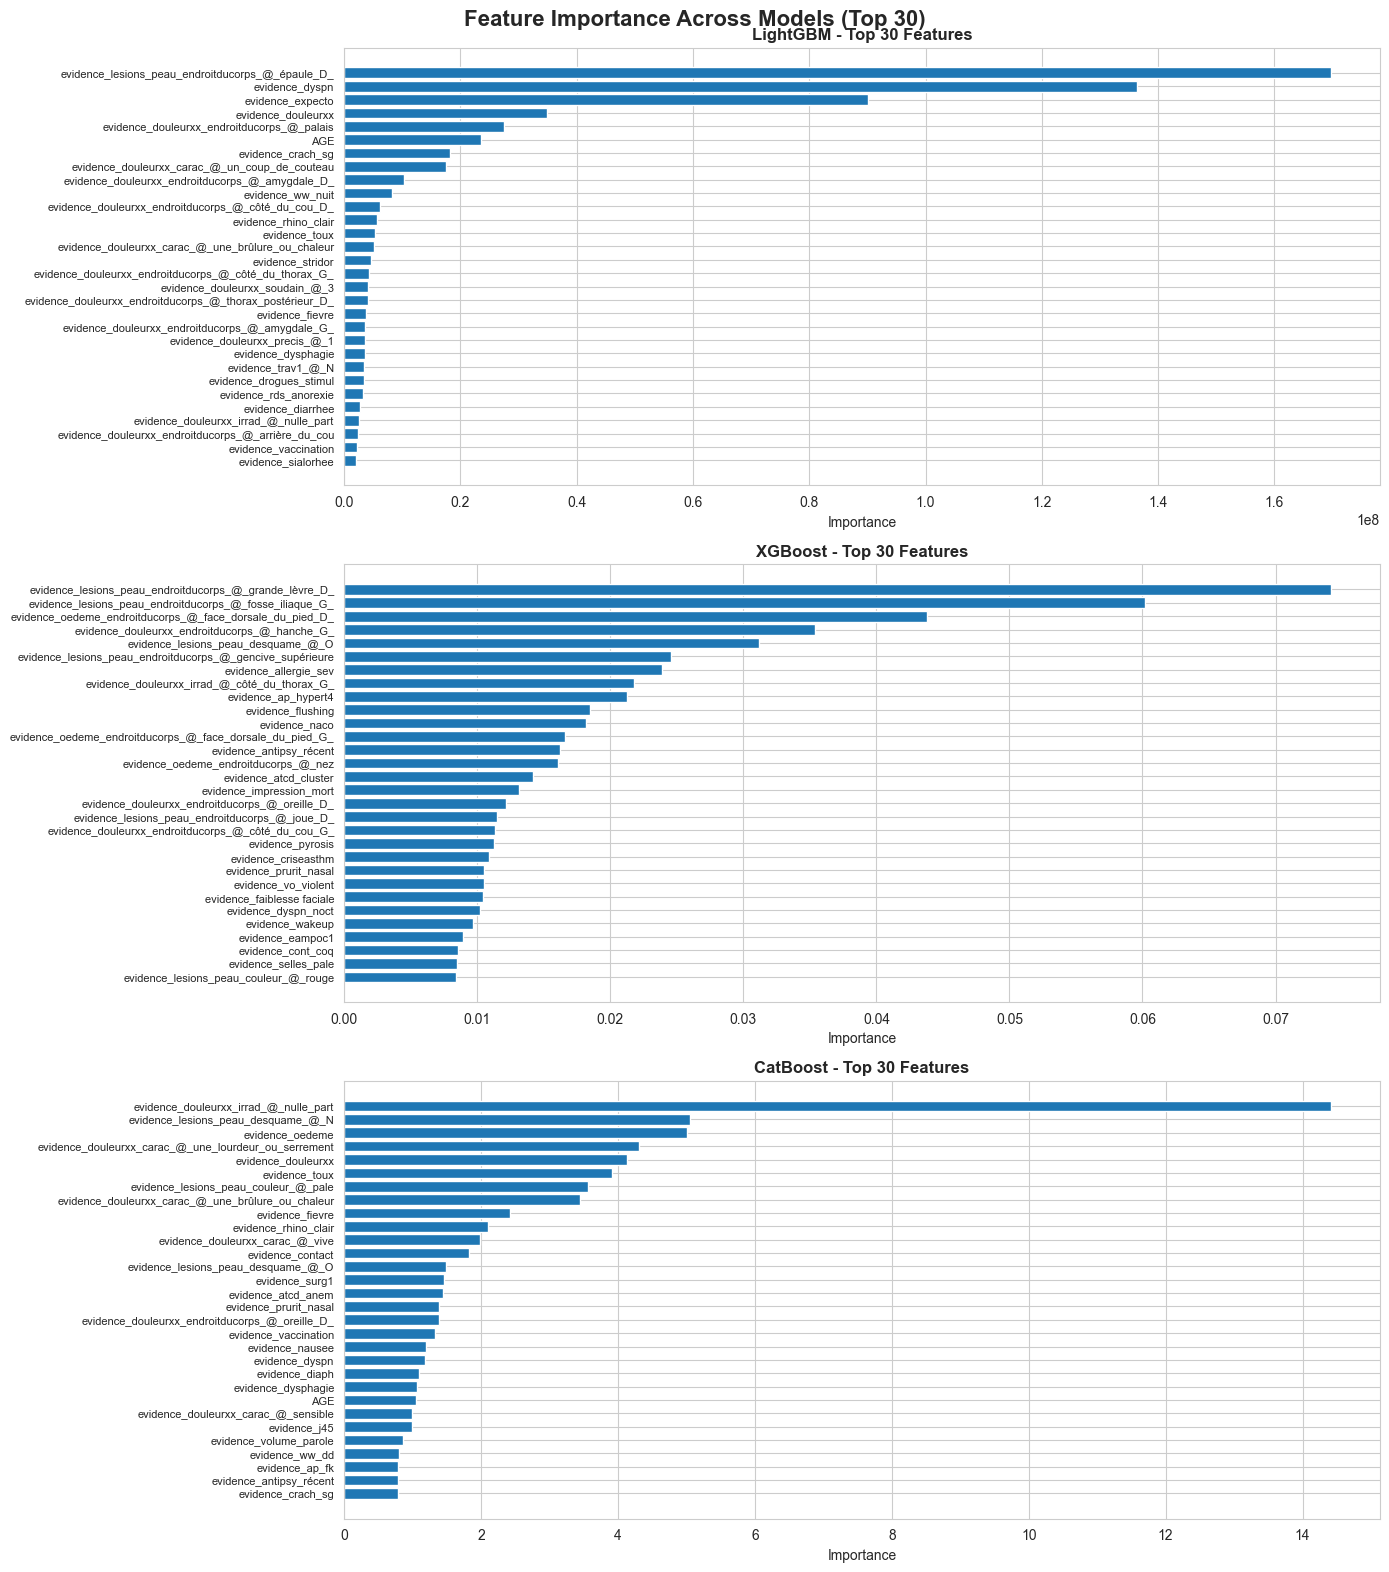

In [16]:
# Visualize feature importance
fig, axes = plt.subplots(3, 1, figsize=(14, 16))
fig.suptitle('Feature Importance Across Models (Top 30)', fontsize=16, fontweight='bold')

# Compute importance DataFrames if missing
import pandas as pd

# LightGBM importance
if 'lgb_model' in globals() and 'lgb_importance_df' not in globals():
    try:
        imp = lgb_model.feature_importance(importance_type='gain')
        lgb_importance_df = pd.DataFrame({'feature': feature_cols, 'importance': imp}).sort_values('importance', ascending=False)
    except Exception as e:
        lgb_importance_df = None

# XGBoost importance
if 'xgb_model' in globals() and 'xgb_importance_df' not in globals():
    try:
        imp = getattr(xgb_model, 'feature_importances_', None)
        if imp is not None and len(imp) == len(feature_cols):
            xgb_importance_df = pd.DataFrame({'feature': feature_cols, 'importance': imp}).sort_values('importance', ascending=False)
        else:
            xgb_importance_df = None
    except Exception as e:
        xgb_importance_df = None

# CatBoost importance
if 'cat_model' in globals() and 'cat_importance_df' not in globals():
    try:
        imp = cat_model.get_feature_importance()
        if imp is not None and len(imp) == len(feature_cols):
            cat_importance_df = pd.DataFrame({'feature': feature_cols, 'importance': imp}).sort_values('importance', ascending=False)
        else:
            cat_importance_df = None
    except Exception as e:
        cat_importance_df = None

model_dfs = [
    ('LightGBM', lgb_importance_df),
    ('XGBoost', xgb_importance_df),
    ('CatBoost', cat_importance_df)
]

for idx, (model_name, importance_df) in enumerate(model_dfs):
    if importance_df is not None and len(importance_df) > 0:
        # Filter out any None or invalid values
        valid_df = importance_df.dropna(subset=['importance'])
        valid_df = valid_df[valid_df['importance'] > 0]
        
        if len(valid_df) > 0:
            top_features = valid_df.head(30)
            
            # Plot
            axes[idx].barh(range(len(top_features)), top_features['importance'].values)
            axes[idx].set_yticks(range(len(top_features)))
            axes[idx].set_yticklabels(top_features['feature'].values, fontsize=8)
            axes[idx].set_title(f'{model_name} - Top 30 Features', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Importance')
            axes[idx].invert_yaxis()
        else:
            axes[idx].text(0.5, 0.5, f'{model_name}: No valid importance data', 
                         ha='center', va='center', fontsize=14)
            axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    else:
        axes[idx].text(0.5, 0.5, f'{model_name}: Not available', 
                     ha='center', va='center', fontsize=14)
        axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


### 2. Correlation Analysis

In [17]:
# 2. Correlation Analysis
print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Check correlations between features and pathology labels
correlations = []
for feat in feature_cols[:100]:  # Check first 100 to avoid memory issues
    try:
        corr = abs(train_df[feat].corr(train_df['PATHOLOGY_ENCODED']))
        if pd.notna(corr):
            correlations.append((feat, corr))
    except:
        pass

# Sort by correlation
correlations = sorted(correlations, key=lambda x: x[1], reverse=True)

print("\nTop 30 Features Most Correlated with Pathology:")
for feat, corr in correlations[:30]:
    print(f"  {feat:50} → {corr:.4f}")

# Check if any features have suspiciously high correlations
high_corr_features = [(f, c) for f, c in correlations if c > 0.7]
print(f"\nFeatures with correlation > 0.7: {len(high_corr_features)}")
if high_corr_features:
    print("\n⚠️  HIGH CORRELATIONS DETECTED:")
    for feat, corr in high_corr_features[:20]:
        print(f"  {feat}: {corr:.4f}")

CORRELATION ANALYSIS

Top 30 Features Most Correlated with Pathology:
  evidence_douleurxx_carac_@_une_crampe              → 0.3234
  evidence_allergie_sev                              → 0.2682
  evidence_contact_allergie                          → 0.2628
  evidence_atcd_anem                                 → 0.2408
  evidence_Mauv_aliment                              → 0.2359
  evidence_atcd_fam_anem                             → 0.2303
  evidence_adp_dlr                                   → 0.2255
  evidence_atcd_its                                  → 0.2245
  evidence_douleurxx_endroitducorps_@_côté_du_thorax_D_ → 0.2211
  evidence_angor_accelere                            → 0.2083
  evidence_douleurxx_endroitducorps_@_côté_du_thorax_G_ → 0.2018
  evidence_criseasthm                                → 0.1816
  evidence_douleurxx_carac_@_écoeurante              → 0.1751
  evidence_bw_bending                                → 0.1736
  evidence_douleurxx_endroitducorps_@_arrière_du_cou → 0

### 3. Evidence-Pathology Associations

In [18]:
# 3. Check for evidence combinations that strongly predict pathologies
print("="*80)
print("EVIDENCE-PATHOLOGY ASSOCIATIONS")
print("="*80)

# Sample a few pathologies to investigate
sample_pathologies = label_encoder.classes_[:10]
print(f"\nInvestigating evidence patterns for: {sample_pathologies}")

# For each pathology, find most common evidences
for pathology in sample_pathologies:
    pathology_num = label_encoder.transform([pathology])[0]
    pathology_samples = train_df[train_df['PATHOLOGY_ENCODED'] == pathology_num]
    
    if len(pathology_samples) > 0:
        print(f"\n{pathology} ({len(pathology_samples)} samples):")
        
        # Find evidences that appear in >90% of cases
        evidence_cols_sample = [col for col in evidence_features[:50]]  # Check first 50
        high_prevalence = []
        
        for col in evidence_cols_sample:
            if col in pathology_samples.columns:
                prevalence = pathology_samples[col].sum() / len(pathology_samples)
                if prevalence > 0.9:  # Present in >90% of cases
                    high_prevalence.append((col, prevalence))
        
        if high_prevalence:
            print(f"  Highly prevalent evidences (>90%):")
            for col, prev in sorted(high_prevalence, key=lambda x: x[1], reverse=True):
                print(f"    {col}: {prev*100:.1f}%")
        else:
            print(f"  No single evidence appears in >90% of cases")

print("\n" + "="*80)

EVIDENCE-PATHOLOGY ASSOCIATIONS

Investigating evidence patterns for: ['Anaphylaxie' 'Angine instable' 'Angine stable' 'Anémie'
 'Asthme exacerbé ou bronchospasme' 'Attaque de panique' 'Bronchiectasies'
 'Bronchiolite' 'Bronchite' 'Chagas']

Anaphylaxie (27864 samples):
  Highly prevalent evidences (>90%):
    evidence_douleurxx: 100.0%

Angine instable (21229 samples):
  Highly prevalent evidences (>90%):
    evidence_douleurxx: 100.0%

Angine stable (17160 samples):
  Highly prevalent evidences (>90%):
    evidence_douleurxx: 100.0%

Anémie (30000 samples):
  Highly prevalent evidences (>90%):
    evidence_douleurxx: 99.0%

Asthme exacerbé ou bronchospasme (19201 samples):
  No single evidence appears in >90% of cases

Attaque de panique (24998 samples):
  Highly prevalent evidences (>90%):
    evidence_douleurxx: 100.0%

Bronchiectasies (18619 samples):
  No single evidence appears in >90% of cases

Bronchiolite (2000 samples):
  No single evidence appears in >90% of cases

Bronchit

### 4. Check for Potential Leakage Sources

In [20]:
# 4. Final leakage check
print("="*80)
print("FINAL LEAKAGE CHECK")
print("="*80)

# Check if DIFFERENTIAL_DIAGNOSIS is actually excluded
print(f"\n1. Checking if DIFFERENTIAL_DIAGNOSIS is in feature_cols:")
if 'DIFFERENTIAL_DIAGNOSIS' in feature_cols:
    print("  ❌ LEAKAGE: DIFFERENTIAL_DIAGNOSIS is in features!")
else:
    print("  ✓ DIFFERENTIAL_DIAGNOSIS properly excluded")

# Check columns in the dataframe
print(f"\n2. Columns in train_df: {len(train_df.columns)}")
print(f"   Sample columns: {train_df.columns[:20].tolist()}")

# Check if there are any suspicious evidence names that might encode pathology
print(f"\n3. Sample evidence features:")
evidence_feat_sample = [c for c in feature_cols if c.startswith('evidence_')][:20]
for feat in evidence_feat_sample:
    print(f"   {feat}")

# Check numeric features
print(f"\n4. Numeric/demographic features:")
numeric_feats = [c for c in feature_cols if c in ['AGE', 'SEX_ENCODED', 'NUM_EVIDENCES', 'NUM_DIFFERENTIAL_DX']]
for feat in numeric_feats:
    print(f"   {feat}")

print("\n" + "="*80)
print("INVESTIGATION COMPLETE")
print("="*80)

FINAL LEAKAGE CHECK

1. Checking if DIFFERENTIAL_DIAGNOSIS is in feature_cols:
  ✓ DIFFERENTIAL_DIAGNOSIS properly excluded

2. Columns in train_df: 592
   Sample columns: ['AGE', 'PATHOLOGY', 'SEX_ENCODED', 'PATHOLOGY_ENCODED', 'evidence_HIV', 'evidence_Mauv_aliment', 'evidence_adp_dlr', 'evidence_ains', 'evidence_allait_prol', 'evidence_allergie_sev', 'evidence_angor_accelere', 'evidence_angor_repos', 'evidence_antipsy_récent', 'evidence_anxiete_s', 'evidence_ap_asian', 'evidence_ap_fk', 'evidence_ap_hypert4', 'evidence_ap_par', 'evidence_ap_pneumothorax', 'evidence_ap_valve']

3. Sample evidence features:
   evidence_HIV
   evidence_Mauv_aliment
   evidence_adp_dlr
   evidence_ains
   evidence_allait_prol
   evidence_allergie_sev
   evidence_angor_accelere
   evidence_angor_repos
   evidence_antipsy_récent
   evidence_anxiete_s
   evidence_ap_asian
   evidence_ap_fk
   evidence_ap_hypert4
   evidence_ap_par
   evidence_ap_pneumothorax
   evidence_ap_valve
   evidence_apnee
   eviden

# Summary and Issues

## What We Have Done

### 1. Data Preprocessing
- Created stratified train/validation/test splits (balanced pathology representation)
- Applied SMOTE for minority classes and random undersampling for majority classes
- Achieved class imbalance reduction from 251.6x to 15x

### 2. Feature Engineering
- One-hot encoded the `EVIDENCES` column → 516 binary evidence features
- One-hot encoded the `INITIAL_EVIDENCE` column → 96 binary initial evidence features
- Removed raw `EVIDENCES` and `INITIAL_EVIDENCE` columns to prevent data leakage
- Excluded non-feature columns: `PATHOLOGY`, `PATHOLOGY_ENCODED`, `DIFFERENTIAL_DIAGNOSIS`, `SEX`

### 3. Filtered Dataset Creation
- Created `DDxPlus Dataset/preprocessed_filtered/` with already encoded features
- **Total features: 616** (including demographics, counts, and encoded evidences)
- Removed potential leakage sources:
  - Raw `EVIDENCES` column (had ICD-10 codes mixed with symptoms)
  - Raw `INITIAL_EVIDENCE` column
  - `TOP_PROBABILITY` and `CONFIDENCE_GAP` (derived from differential diagnosis)

### 4. Model Training
- Trained 3 gradient boosting models (LightGBM, XGBoost, CatBoost)
- Used early stopping and standard hyperparameters
- Evaluated on validation set with multiple metrics

---

## Current Problem: Suspiciously High Results

### Symptoms:
- Accuracy: ~99.5% (unrealistically high for medical diagnosis)
- Top-3 Accuracy: ~100% (almost perfect)
- All three models showing similar suspiciously high performance

### Possible Causes:

1. **Data Leakage Source Unknown**: Despite removing:
   - Raw evidence columns
   - Differential diagnosis probabilities
   - Some feature still contains the answer

2. **Possible Issues**:
   - **EVIDENCES column may have contained pathology-specific patterns** that leaked into one-hot features
   - **DIFFERENTIAL_DIAGNOSIS column exists in the data** - need to verify it's actually excluded
   - **Evidence names themselves** might encode pathology information
   - Model may be finding spurious correlations in high-dimensional space

3. **Not Investigated Yet**:
   - Feature importance analysis to see what drives predictions
   - Correlation analysis between evidence features and pathologies
   - Check if certain evidence combinations perfectly predict pathologies
   - Test model on completely new pathologies not seen during training

### Next Steps:
1. Inspect feature importance from trained models to identify suspicious patterns
2. Check for highly correlated features with pathology labels
3. Investigate if evidence names contain pathology information
4. Consider that this might actually be valid if the dataset contains very clear diagnostic patterns
5. Test on a truly held-out test set

from paper: "The dataset's synthetic nature and use of a comprehensive KB with likelihood ratios enable strong pattern recognition, likely contributing to high model performance."

## Step 1: Expand Leakage Filter for Non-ICD Diagnostics

Enhance leakage filtering to remove diagnostic-like antecedents (e.g., `ap_`, `atcd_`, explicit diseases like `HIV`, `COPD`, etc.) that may act as proxies for the target.


In [21]:
import re

# Enhanced detector for diagnostic/leaky features

def is_diagnostic_like(feature_name: str) -> bool:
    name = feature_name.replace('evidence_', '').replace('initial_', '').lower()

    # ICD-10 patterns (expanded)
    icd_patterns = [
        r'^[A-Z][0-9]{1,4}(\.[0-9]{1,3})?$',
        r'^[a-z][0-9]+(-|_)[0-9]+$',
        r'^[a-z]{1,2}[0-9]+(\.[0-9]+)+$',
        r'^[A-Z][0-9]{2,4}.*$'
    ]

    # Disease keywords and history prefixes
    disease_keywords = [
        'hiv', 'copd', 'cancer', 'diabetes', 'pneumonia', 'tuberculosis', 'asthma',
        'hypert', 'valve', 'pneumothorax', 'anem', 'cluster', 'par', 'fk',
        'allait_prol', 'allergie_sev', 'angor', 'antipsy', 'ap_asian'
    ]

    if name.startswith('ap_') or name.startswith('atcd_') or any(kw in name for kw in disease_keywords):
        return True

    return any(re.match(p, name) for p in icd_patterns)

# Identify and remove leaky features
leaky_features = [col for col in feature_cols if is_diagnostic_like(col)]
print(f"Found {len(leaky_features)} leaky features: {leaky_features[:20]}...")

# Create cleaned feature sets (exclude leaky and count-based features if any)
exclude_extra = ['NUM_EVIDENCES', 'NUM_DIFFERENTIAL_DX']
clean_feature_cols = [col for col in feature_cols if col not in leaky_features and col not in exclude_extra]

# Update X datasets
X_train_clean = train_df[clean_feature_cols]
X_val_clean   =   val_df[clean_feature_cols]
X_test_clean  =  test_df[clean_feature_cols]

print(f"Cleaned features: {len(clean_feature_cols)} (original: {len(feature_cols)})")

# Optional: save cleaned column-only datasets for reproducibility
pd.DataFrame({'feature': clean_feature_cols}).to_csv('../results/clean_feature_columns.csv', index=False)
train_df[clean_feature_cols + ['PATHOLOGY_ENCODED']].to_csv('../results/clean_train.csv', index=False)
val_df[clean_feature_cols + ['PATHOLOGY_ENCODED']].to_csv('../results/clean_validation.csv', index=False)
test_df[clean_feature_cols + ['PATHOLOGY_ENCODED']].to_csv('../results/clean_test.csv', index=False)
print("Saved cleaned datasets to ../results/")


Found 35 leaky features: ['evidence_HIV', 'evidence_allait_prol', 'evidence_allergie_sev', 'evidence_angor_accelere', 'evidence_angor_repos', 'evidence_antipsy_récent', 'evidence_ap_asian', 'evidence_ap_fk', 'evidence_ap_hypert4', 'evidence_ap_par', 'evidence_ap_pneumothorax', 'evidence_ap_valve', 'evidence_atcd_anem', 'evidence_atcd_cluster', 'evidence_atcd_fam_anem', 'evidence_atcd_its', 'evidence_cancer_méta', 'evidence_douleurxx_endroitducorps_@_nulle_part', 'evidence_douleurxx_irrad_@_nulle_part', 'evidence_lesions_peau_endroitducorps_@_nulle_part']...
Cleaned features: 555 (original: 590)
Saved cleaned datasets to ../results/


## Step 2: Retrain LightGBM on Cleaned Features and Analyze Importance
Train a LightGBM model using `clean_feature_cols` and confirm that top features are symptoms rather than diagnostic antecedents. Save plot and printed importances.


Training LightGBM on cleaned features...
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 33.6138	val's multi_logloss: 33.6899
Early stopping, best iteration is:
[15]	train's multi_logloss: 0.0646432	val's multi_logloss: 0.0711194
Clean LGBM - Val Accuracy: 0.9937, Macro F1: 0.9883, Weighted F1: 0.9937


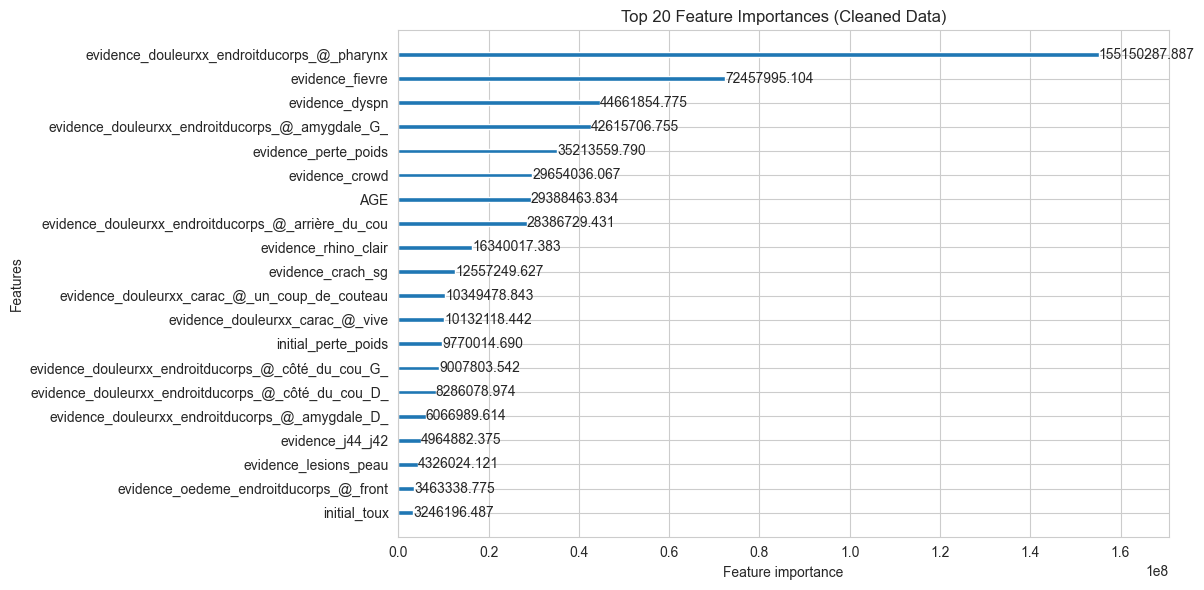

                                           Feature   Importance
       evidence_douleurxx_endroitducorps_@_pharynx 1.551503e+08
                                   evidence_fievre 7.245800e+07
                                    evidence_dyspn 4.466185e+07
   evidence_douleurxx_endroitducorps_@_amygdale_G_ 4.261571e+07
                              evidence_perte_poids 3.521356e+07
                                    evidence_crowd 2.965404e+07
                                               AGE 2.938846e+07
evidence_douleurxx_endroitducorps_@_arrière_du_cou 2.838673e+07
                              evidence_rhino_clair 1.634002e+07
                                 evidence_crach_sg 1.255725e+07
Saved cleaned LightGBM model to ../saved_models/lightgbm_model_clean.txt


In [22]:
# Helper: train LightGBM with early stopping (clean features)

def train_lgb(X_train, y_train, X_val, y_val):
    params = {
        'objective': 'multiclass',
        'num_class': len(label_encoder.classes_),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, free_raw_data=False)
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
    )
    return model

print("Training LightGBM on cleaned features...")
lgb_model_clean = train_lgb(X_train_clean, y_train, X_val_clean, y_val)

# Evaluate on validation
val_proba_clean = lgb_model_clean.predict(X_val_clean, num_iteration=lgb_model_clean.best_iteration)
val_pred_clean = np.argmax(val_proba_clean, axis=1)
acc_clean = accuracy_score(y_val, val_pred_clean)
f1_macro_clean = f1_score(y_val, val_pred_clean, average='macro')
f1_weighted_clean = f1_score(y_val, val_pred_clean, average='weighted')
print(f"Clean LGBM - Val Accuracy: {acc_clean:.4f}, Macro F1: {f1_macro_clean:.4f}, Weighted F1: {f1_weighted_clean:.4f}")

# Plot and save feature importance (gain)
ax = lgb.plot_importance(lgb_model_clean, max_num_features=20, importance_type='gain')
plt.title('Top 20 Feature Importances (Cleaned Data)')
plt.tight_layout()
plt.savefig('../results/feature_importance_clean.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top 10 importances
importances = pd.DataFrame({
    'Feature': clean_feature_cols,
    'Importance': lgb_model_clean.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False).head(10)
print(importances.to_string(index=False))

# Save clean model
from pathlib import Path
save_dir = Path('../saved_models')
save_dir.mkdir(parents=True, exist_ok=True)
lgb_clean_path = save_dir / 'lightgbm_model_clean.txt'
lgb_model_clean.save_model(str(lgb_clean_path))
print(f"Saved cleaned LightGBM model to {lgb_clean_path}")


## Step 3: Robustness Test — Mask 30% of Evidence Features at Test Time
Simulate incomplete information by masking a random subset of evidence features in the test set and evaluating the cleaned model.


In [23]:
import numpy as np

# Function to mask random percentage of evidence features

def mask_evidences(X: pd.DataFrame, mask_pct: float = 0.3) -> pd.DataFrame:
    evidence_cols = [col for col in X.columns if col.startswith('evidence_')]
    num_mask = int(len(evidence_cols) * mask_pct)
    if num_mask <= 0:
        return X.copy()
    mask_cols = np.random.choice(evidence_cols, num_mask, replace=False)
    X_masked = X.copy()
    X_masked.loc[:, mask_cols] = 0  # Set masked evidences to absent
    return X_masked

X_test_masked = mask_evidences(X_test_clean, mask_pct=0.3)
num_masked = int(0.3 * len([c for c in clean_feature_cols if c.startswith('evidence_')]))
print(f"Masked approximately {num_masked} evidence features in the test set.")

# Evaluate cleaned model on masked test
proba_masked = lgb_model_clean.predict(X_test_masked, num_iteration=lgb_model_clean.best_iteration)
y_pred_masked = np.argmax(proba_masked, axis=1)
from sklearn.metrics import accuracy_score, f1_score
print(f"Accuracy on masked test: {accuracy_score(y_test, y_pred_masked):.4f}")
print(f"Macro F1 on masked test: {f1_score(y_test, y_pred_masked, average='macro'):.4f}")

# Top-3 accuracy on masked test
top3_pred_m = np.argsort(proba_masked, axis=1)[:, -3:]
top3_acc_m = np.mean([y_test.iloc[i] in top3_pred_m[i] for i in range(len(y_test))])
print(f"Top-3 Accuracy on masked test: {top3_acc_m:.4f}")


Masked approximately 139 evidence features in the test set.
Accuracy on masked test: 0.7922
Macro F1 on masked test: 0.7832
Top-3 Accuracy on masked test: 0.9694


## Step 4: 5-Fold Cross-Validation Baseline (Logistic Regression)
Combine train+val on cleaned features, run 5-fold CV with a simple baseline to gauge task difficulty independent of GBMs.


In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Combine train+val
X_cv = pd.concat([X_train_clean, X_val_clean], axis=0)
y_cv = pd.concat([y_train, y_val], axis=0)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_cv, y_cv), start=1):
    X_tr, X_va = X_cv.iloc[tr_idx], X_cv.iloc[va_idx]
    y_tr, y_va = y_cv.iloc[tr_idx], y_cv.iloc[va_idx]

    lr = LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs', n_jobs=-1)
    lr.fit(X_tr, y_tr)
    y_va_pred = lr.predict(X_va)
    acc = accuracy_score(y_va, y_va_pred)
    cv_acc.append(acc)
    print(f"Fold {fold}: Accuracy = {acc:.4f}")

print(f"5-Fold CV Accuracy (Baseline LR): Mean {np.mean(cv_acc):.4f}, Std {np.std(cv_acc):.4f}")


Fold 1: Accuracy = 0.9899
Fold 2: Accuracy = 0.9930
Fold 3: Accuracy = 0.9916
Fold 4: Accuracy = 0.9923
Fold 5: Accuracy = 0.9925
5-Fold CV Accuracy (Baseline LR): Mean 0.9919, Std 0.0011


## Step 6 (Optional): Add Noise to Binary Features
Flip 10% of binary features to simulate noise; you can retrain/evaluate on this noisy variant if needed.


In [25]:
def add_noise(X: pd.DataFrame, noise_pct: float = 0.1) -> pd.DataFrame:
    Xn = X.copy()
    binary_cols = [c for c in Xn.columns if Xn[c].nunique() == 2]
    rng = np.random.default_rng(42)
    for col in binary_cols:
        flip_mask = rng.random(len(Xn)) < noise_pct
        Xn.loc[flip_mask, col] = 1 - Xn.loc[flip_mask, col]
    return Xn

# Example usage (disabled by default):
X_train_noisy = add_noise(X_train_clean, 0.1)
X_val_noisy   = add_noise(X_val_clean, 0.1)
X_test_noisy  = add_noise(X_test_clean, 0.1)
# You can then retrain/evaluate using these noisy variants.


## Final: Retrain All GBMs on Cleaned Features and Evaluate (Val + Test)
Train LightGBM, XGBoost, CatBoost on `clean_feature_cols`, evaluate on validation and test, compute Top-3, classification reports, confusion matrices, and save models and artifacts.


Training GBMs on cleaned features...
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 33.6138	val's multi_logloss: 33.6899
Early stopping, best iteration is:
[15]	train's multi_logloss: 0.0646432	val's multi_logloss: 0.0711194
LGBM Clean - Val: Acc=0.9937 MacroF1=0.9883 Top3=0.9997
LGBM Clean - Test: Acc=0.9937 MacroF1=0.9876 Top3=0.9997


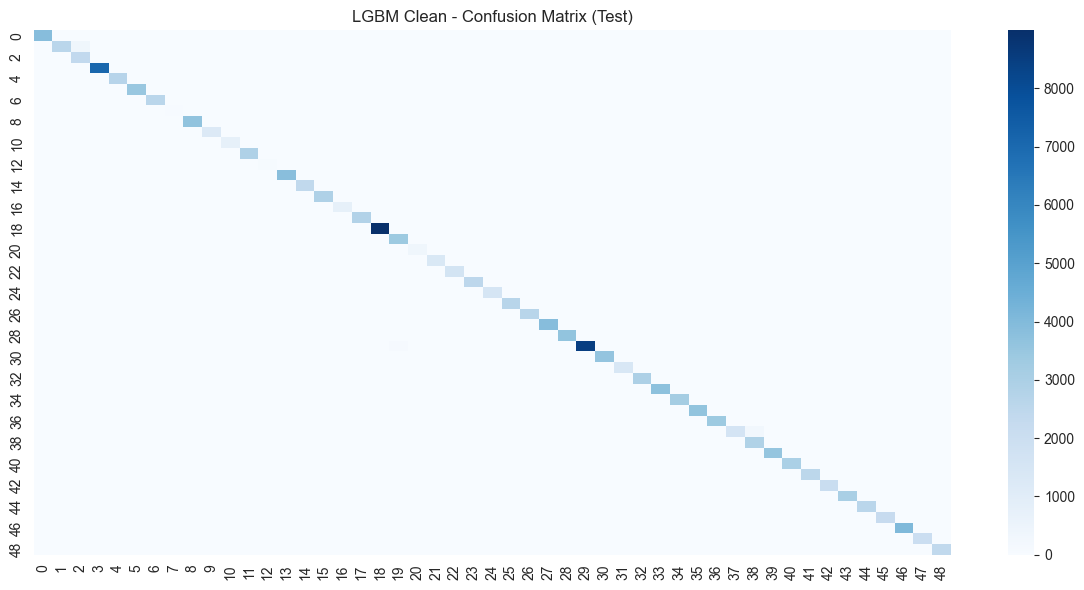

[0]	validation_0-mlogloss:1.71110	validation_1-mlogloss:1.70920
[50]	validation_0-mlogloss:0.02988	validation_1-mlogloss:0.02958
[100]	validation_0-mlogloss:0.01500	validation_1-mlogloss:0.01566
[150]	validation_0-mlogloss:0.01290	validation_1-mlogloss:0.01510
[200]	validation_0-mlogloss:0.01143	validation_1-mlogloss:0.01516
[220]	validation_0-mlogloss:0.01088	validation_1-mlogloss:0.01521
XGB Clean - Val: Acc=0.9947 MacroF1=0.9938 Top3=1.0000
XGB Clean - Test: Acc=0.9948 MacroF1=0.9939 Top3=1.0000


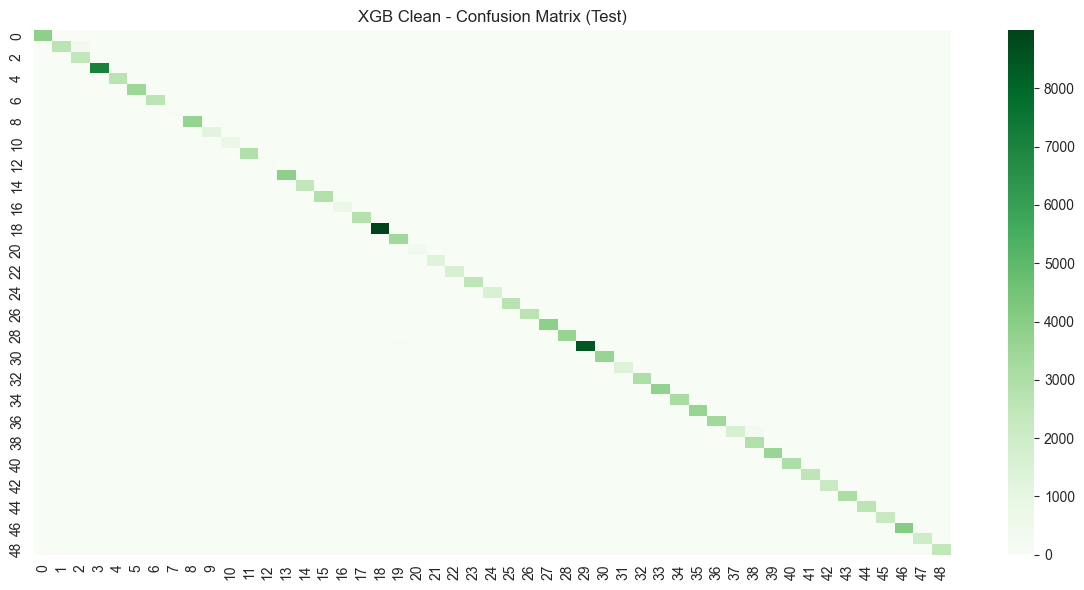

0:	learn: 2.9898895	test: 3.0102204	best: 3.0102204 (0)	total: 4.34s	remaining: 1h 12m 11s
50:	learn: 0.3538485	test: 0.3466155	best: 0.3466155 (50)	total: 3m 28s	remaining: 1h 4m 39s
100:	learn: 0.1387431	test: 0.1360770	best: 0.1360770 (100)	total: 6m 56s	remaining: 1h 1m 49s
150:	learn: 0.0738221	test: 0.0724782	best: 0.0724782 (150)	total: 10m 26s	remaining: 58m 42s
200:	learn: 0.0487118	test: 0.0478558	best: 0.0478558 (200)	total: 13m 51s	remaining: 55m 5s
250:	learn: 0.0369422	test: 0.0362143	best: 0.0362143 (250)	total: 17m 18s	remaining: 51m 38s
300:	learn: 0.0300913	test: 0.0293571	best: 0.0293571 (300)	total: 20m 47s	remaining: 48m 16s
350:	learn: 0.0261042	test: 0.0254495	best: 0.0254495 (350)	total: 24m 17s	remaining: 44m 54s
400:	learn: 0.0236091	test: 0.0231008	best: 0.0231008 (400)	total: 27m 46s	remaining: 41m 29s
450:	learn: 0.0218241	test: 0.0214892	best: 0.0214892 (450)	total: 31m 5s	remaining: 37m 51s
500:	learn: 0.0205978	test: 0.0204395	best: 0.0204395 (500)	total

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Helper to compute top-3 accuracy from proba matrix

def top3_acc_from_proba(y_true, proba):
    top3_idx = np.argsort(proba, axis=1)[:, -3:]
    return np.mean([y_true.iloc[i] in top3_idx[i] for i in range(len(y_true))])

from pathlib import Path
art_dir = Path('../results')
art_dir.mkdir(parents=True, exist_ok=True)
models_dir = Path('../saved_models')
models_dir.mkdir(parents=True, exist_ok=True)

print("Training GBMs on cleaned features...")

# LightGBM (clean)
lgb_clean = train_lgb(X_train_clean, y_train, X_val_clean, y_val)
val_proba = lgb_clean.predict(X_val_clean, num_iteration=lgb_clean.best_iteration)
val_pred  = np.argmax(val_proba, axis=1)
val_top3  = top3_acc_from_proba(y_val, val_proba)
print("LGBM Clean - Val:",
      f"Acc={accuracy_score(y_val, val_pred):.4f}",
      f"MacroF1={f1_score(y_val, val_pred, average='macro'):.4f}",
      f"Top3={val_top3:.4f}")
# Test
proba_t = lgb_clean.predict(X_test_clean, num_iteration=lgb_clean.best_iteration)
pred_t  = np.argmax(proba_t, axis=1)
print("LGBM Clean - Test:",
      f"Acc={accuracy_score(y_test, pred_t):.4f}",
      f"MacroF1={f1_score(y_test, pred_t, average='macro'):.4f}",
      f"Top3={top3_acc_from_proba(y_test, proba_t):.4f}")
# Save model and reports
lgb_clean.save_model(str(models_dir / 'lightgbm_model_clean_all.txt'))
rep = classification_report(y_test, pred_t, output_dict=False)
open(art_dir / 'lgb_clean_classification_report.txt', 'w').write(rep)
cm = confusion_matrix(y_test, pred_t)
sns.heatmap(cm, cmap='Blues')
plt.title('LGBM Clean - Confusion Matrix (Test)')
plt.tight_layout(); plt.savefig(art_dir / 'lgb_clean_confusion_matrix.png', dpi=300); plt.show()

# XGBoost (clean)
xgb_clean = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)
xgb_clean.fit(X_train_clean, y_train, eval_set=[(X_train_clean, y_train), (X_val_clean, y_val)], verbose=50)
val_pred_x = xgb_clean.predict(X_val_clean)
val_proba_x = xgb_clean.predict_proba(X_val_clean)
print("XGB Clean - Val:",
      f"Acc={accuracy_score(y_val, val_pred_x):.4f}",
      f"MacroF1={f1_score(y_val, val_pred_x, average='macro'):.4f}",
      f"Top3={top3_acc_from_proba(y_val, val_proba_x):.4f}")
# Test
pred_tx = xgb_clean.predict(X_test_clean)
proba_tx = xgb_clean.predict_proba(X_test_clean)
print("XGB Clean - Test:",
      f"Acc={accuracy_score(y_test, pred_tx):.4f}",
      f"MacroF1={f1_score(y_test, pred_tx, average='macro'):.4f}",
      f"Top3={top3_acc_from_proba(y_test, proba_tx):.4f}")
# Save
xgb_clean.save_model(str(models_dir / 'xgboost_model_clean.json'))
rep = classification_report(y_test, pred_tx, output_dict=False)
open(art_dir / 'xgb_clean_classification_report.txt', 'w').write(rep)
cm = confusion_matrix(y_test, pred_tx)
sns.heatmap(cm, cmap='Greens')
plt.title('XGB Clean - Confusion Matrix (Test)')
plt.tight_layout(); plt.savefig(art_dir / 'xgb_clean_confusion_matrix.png', dpi=300); plt.show()

# CatBoost (clean)
cat_clean = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=42,
    verbose=50,
    early_stopping_rounds=50
)
cat_clean.fit(X_train_clean, y_train, eval_set=(X_val_clean, y_val), use_best_model=True)
val_pred_c = cat_clean.predict(X_val_clean)
val_proba_c = cat_clean.predict_proba(X_val_clean)
print("CAT Clean - Val:",
      f"Acc={accuracy_score(y_val, val_pred_c):.4f}",
      f"MacroF1={f1_score(y_val, val_pred_c, average='macro'):.4f}",
      f"Top3={top3_acc_from_proba(y_val, val_proba_c):.4f}")
# Test
pred_tc = cat_clean.predict(X_test_clean)
proba_tc = cat_clean.predict_proba(X_test_clean)
print("CAT Clean - Test:",
      f"Acc={accuracy_score(y_test, pred_tc):.4f}",
      f"MacroF1={f1_score(y_test, pred_tc, average='macro'):.4f}",
      f"Top3={top3_acc_from_proba(y_test, proba_tc):.4f}")
# Save
cat_clean.save_model(str(models_dir / 'catboost_model_clean.cbm'))
rep = classification_report(y_test, pred_tc, output_dict=False)
open(art_dir / 'cat_clean_classification_report.txt', 'w').write(rep)
cm = confusion_matrix(y_test, pred_tc)
sns.heatmap(cm, cmap='Purples')
plt.title('CatBoost Clean - Confusion Matrix (Test)')
plt.tight_layout(); plt.savefig(art_dir / 'cat_clean_confusion_matrix.png', dpi=300); plt.show()

print("\nAll cleaned models trained, evaluated, and saved.")
